# H.

In [33]:
import math
import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv('input/h_train.txt', sep='\t', header=None)
df = df.replace(-1, np.nan)
df = df.fillna(np.nanmean(df[[1, 2]]))
print(df.shape)
df.head()

(1000, 5)


0         1         2         3         4
0  0.5  8.154642  7.945215  0.000552  0.000483
1  1.0  7.945215  9.105132  0.075709  0.024765
2  0.0  7.349630  7.945215  0.045557  0.006901
3  0.0  7.077312  7.945215  0.000369  0.004083
4  1.0  7.945215  7.945215  0.002481  0.002171

Let's see how ratings are distributed

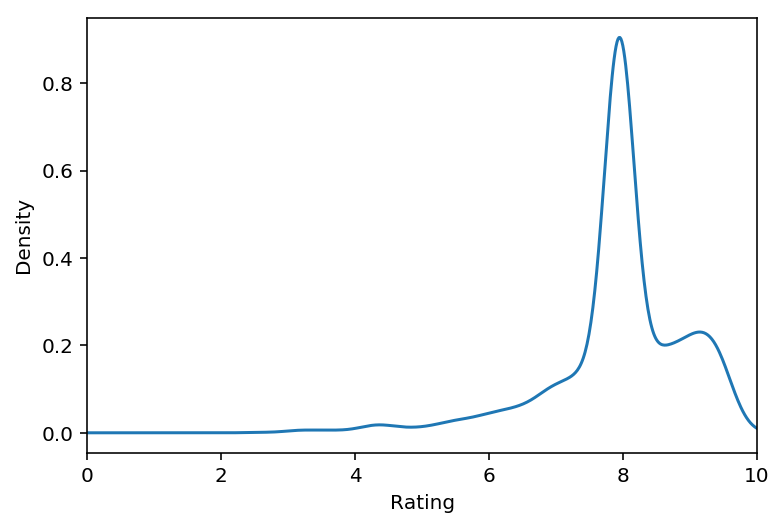

In [18]:
ax = df[[1, 2]].stack().plot(kind='kde', xlim=(0, 10))
ax.xaxis.set_label_text('Rating');

We see the distribution is skewed towards higher ratings, we can try to fix that via exponentiation

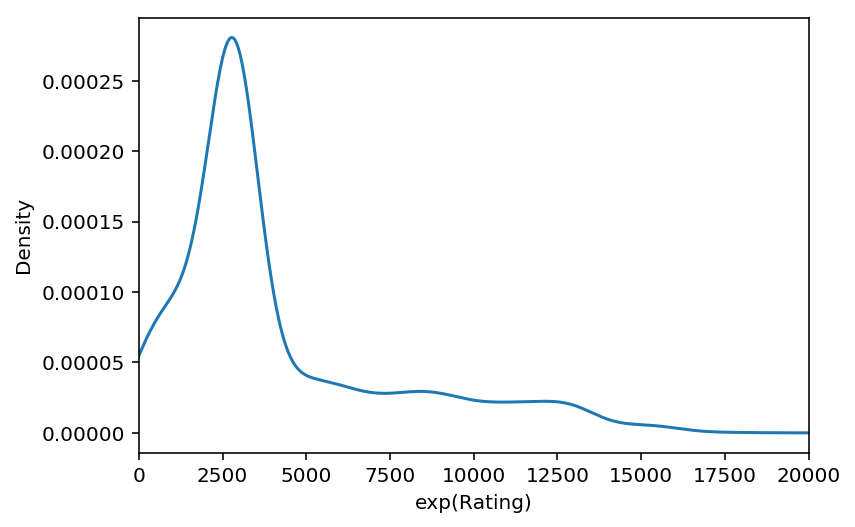

In [22]:
ax = np.exp(df[[1, 2]]).stack().plot(kind='kde', xlim=(0, 20000))
ax.xaxis.set_label_text('exp(Rating)');

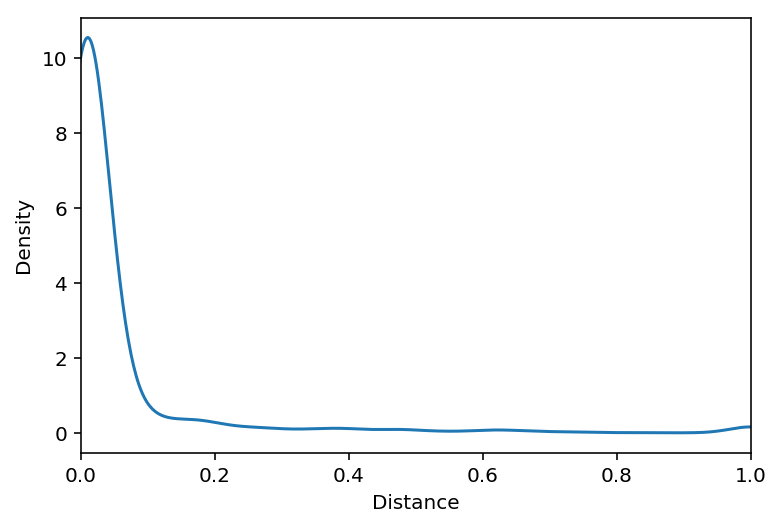

In [16]:
ax = df[[3, 4]].stack().plot(kind='kde', xlim=(0, 1))
ax.xaxis.set_label_text('Distance');

Distance distribution is very skewed. There are a lot of small distances, so we can try to normalize distribution
by log-transforming it.

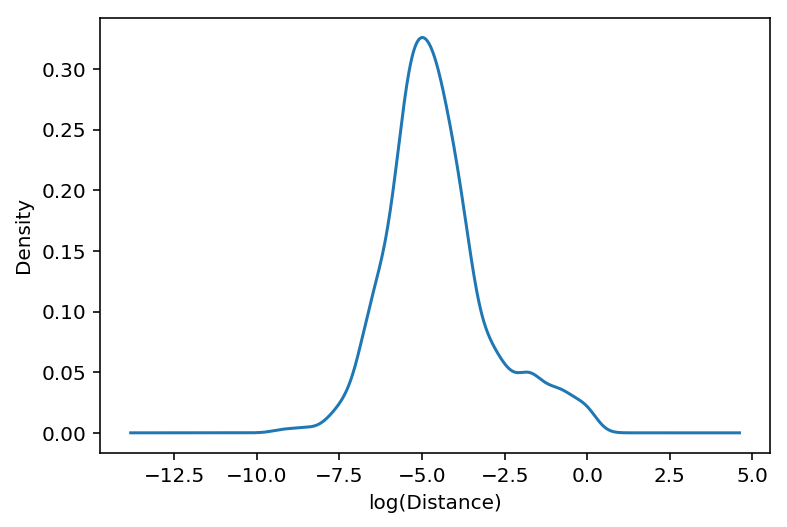

In [25]:
ax = np.log(df[[3, 4]].stack() + 0.0001).plot(kind='kde')
ax.xaxis.set_label_text('log(Distance)');

That looks much more normal!

Let's prepare some features based on our observations:

In [31]:
df['d1'] = np.log(df[3] + 0.0001)
df['d2'] = np.log(df[4] + 0.0001)
df['r1'] = np.exp(df[1])
df['r2'] = np.exp(df[2])
r_mean = df[[1, 2]].values.mean()
r_exp_mean = df[['r1', 'r2']].values.mean()
r_exp_std = df[['r1', 'r2']].values.std()
d_log_mean = df[['d1', 'd2']].values.mean()
d_log_std = df[['d1', 'd2']].values.std()
df['r1'], df['r2'] = (df['r1'] - r_exp_mean) / r_exp_std, (df['r2'] - r_exp_mean) / r_exp_std
df['d1'], df['d2'] = (df['d1'] - d_log_mean) / d_log_std, (df['d2'] - d_log_mean) / d_log_std
df['r_diff'] = df['r1'] - df['r2']
df['d_diff'] = df['d1'] - df['d2']

Actually, at first I tried to use original features without those transformations but the results were worse.

We will use a simple linear model to predict restaurant scores based on distance and rating:

$$score_i=w_1 r_i + w_2 d_i = W\begin{pmatrix}r_i \\ d_i\end{pmatrix}$$

We would like scores to be such that:

$$
\sigma(score_i - score_j) = \sigma \left (  W\begin{pmatrix}r_i-r_j \\ d_i-d_j\end{pmatrix} \right ) =
\begin{cases}
0 & \text{ if restaurant } \textit{ j } \text{ is winner  } \\ 
0.5 & \text{ if tie} \\ 
1 & \text{ if restaurant } \textit{ i } \text{ is winner  } \\ 
\end{cases}
$$

Were $\sigma(x) = \frac{1}{1 + e^{-x}}$ - is sigmoid fuction.

We see that it looks similar to logistic regression with 2 weights. So we can write simple iterative algorithm to find those weights based on our data:

In [74]:
w = np.zeros(2)
x = df[['r_diff', 'd_diff']].values
y = 1 - df[0].values
v = np.zeros_like(w)
for i in range(10000):
    z = w @ x.T
    h = 1 / (1 + np.exp(-z))
    gradient = x.T @ (h - y) / x.shape[0]
    v = 0.9 * v + 0.01 * gradient
    w -= v

print('W =', w)

W = [ 0.6450431  -1.65655934]


Let's calculate scores

In [37]:
df['s1'] = df[['r1', 'd1']] @ w
df['s2'] = df[['r2', 'd2']] @ w
df['s_diff'] = df['s1'] - df['s2']

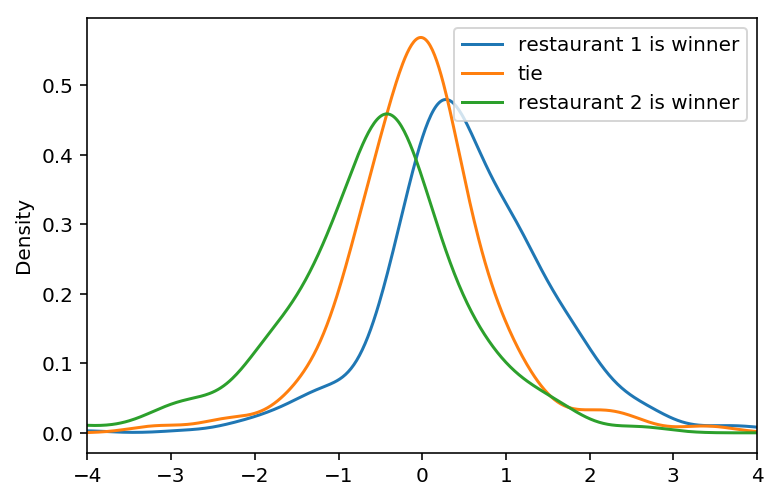

In [70]:
ax = df[[0, 's_diff']].groupby(0)['s_diff'].plot(kind='kde', xlim=(-4, 4))
ax[0].legend(('restaurant 1 is winner', 'tie', 'restaurant 2 is winner'));

Now we can use obtained coefficients for linear model to predict scores in test data. See `h.py` for details.